# wdtools: Tutorial

Vedant Chandra, Hsiang-Chih Hwang, Nadia L. Zakamska. <br>
Department of Physics and Astronomy, Johns Hopkins University

In [45]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import sys
sys.path.append('../') # Your path should contain the parent GitHub repository

import wdtools

For this demonstration, we use a sample spectrum from the Sloan Digital Sky Survey (SDSS) named SDSS J082600.58+282346.2. 

Tremblay et al. (2019) assigned this star an effective temperature of $13917$ Kelvin and a surface gravity of $8.06$ log[cm/s^2] using their latest atmospheric models and this SDSS spectrum. In this notebook we'll demonstrate how you can use `wdtools` to infer these parameters from any white dwarf spectrum. 

In [15]:
with fits.open('sample_spectrum.fits') as f:
    flux = f[1].data['flux']
    wl = 10**f[1].data['loglam']
    ivar = f[1].data['ivar']

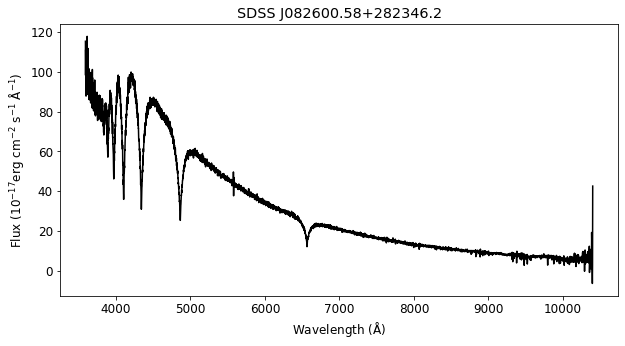

In [17]:
plt.figure(figsize = (10,5))
plt.plot(wl, flux, 'k')
plt.xlabel('Wavelength ($\mathrm{\AA}$)');
plt.ylabel('Flux ($\mathrm{10^{-17} erg\ cm^{-2}\ s^{-1}\ \AA^{-1}}$)')
plt.title('SDSS J082600.58+282346.2');

## Generative Fitting Pipeline

We normalize the hydrogen Balmer lines and fit atmospheric models from Koester (2010) to this spectrum using our MCMC algorithm.

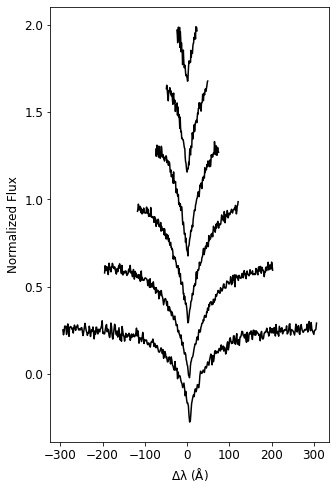

In [18]:
sp = wdtools.SpecTools() # Load the SpecTools class from wdtools

wl_norm, flux_norm, ivar_norm = sp.normalize_balmer(wl, flux, ivar, 
                                                    lines = ['alpha', 'beta', 'gamma', 'delta', 'eps', 'h8'],
                                                    make_stackedplot = True, make_subplot = False)

If your spectrum was obtained from a different instrument and/or only has some subset of the Balmer lines, you can pass a different list of `lines` to normalize. The subsequent fitting process interpolates models onto the normalized and cropped wavelength grid, and therefore works for any selection of lines. Usually it's a good idea to use the higher-order Balmer lines since they are more sensitive to surface gravity and temperature. 

In [21]:
gfp = wdtools.GFP(resolution = 3, specclass = 'DA')

We pass the instrumental resolution in Angstroms when we initialize `GFP`. The theoretical models are convolved with a Gaussian kernel with this resolution prior to each fitting step. We also select the `'DA'` spectral class to fit pure-hydrogen models. At this time, these are the only models available. In future we hope to include helium (DB) models when those models become publicly available. 

finding optimal starting point with differential evolution...


100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


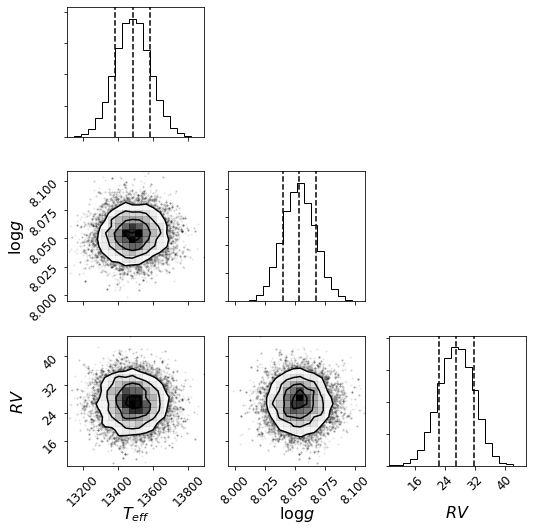

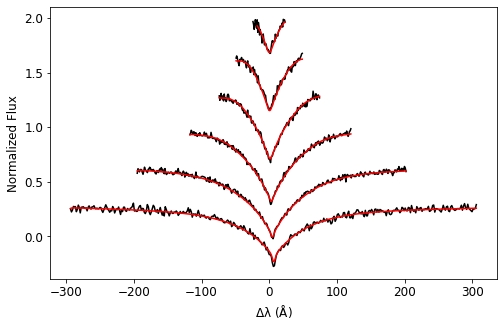

In [20]:
sampler = gfp.fit_spectrum(wl_norm, flux_norm, ivar_norm, init = 'de', nwalkers = 250, burn = 100, ndraws = 100,
                    make_plot = True, plot_trace = False, savename = 'example')

All parameters passed to `gfp.fit_spectrum` other than the normalized wavelength and flux are optional. If no inverse variance `ivar` array is passed, then the software will estimate the flux uncertainty using the beta-sigma method. This will make the $\chi^2$ likelihood inexact, so treat the parameter posterior distributions with caution.

We initialize the sampling at a high-probability region of parameter space by finding parameters that minimize the $\chi^2$ using a differential evolution (`'de'`) solver. Methods like these can be susceptible to initial conditions and may cause you to ignore a multimodal likelihood. 

We recommend first fitting the spectrum with a uniform (`init = 'unif'`) burn in to ascertain if the likelihood is multimodal, and then performing a production run with `init = 'de'` or `init = 'mle'`. The latter uses uniform MCMC sampling instead of a solving algorithm to find the initial high-probability region, and is therefore less susceptible to initial conditions. 

The MCMC hyperparameter selection involves a trade-off between accuracy and speed. Unless you have a particular need for more samples or quicker sampling, you can leave them at the default settings, which should enable you to fit a single spectrum in under a minute on a regular laptop computer. We recommend keeping `burn` greater than 100 steps at least, so that walkers can spread out from the high-probability starting point and explore the likelehood. Otherwise, the errors on fitted parameters can be grossly underestimated. 

In [23]:
medians = np.median(sampler.flatchain, axis = 0)
iqrs = stats.iqr(sampler.flatchain, axis = 0, rng = (0.16, 0.84))

There is a lot of literature regarding which summary statistics to use to describe the posterior MCMC samples. Assuming the posteriors look roughly Gaussian (which they do in this case), we prefer using the median of each parameter, along with the inter-quantile range between the 16% and 84% percentiles of the samples. This should correspond to the 1-$\sigma$ uncertainty in the fitted parameters. By computing the medians of each paramter independently rather that picking one 'best-fit' sample, we marginalize the parameters against each other. 

In case you'd rather pick the parameters that minimize $\chi^2$ during a single step, you can use:

In [37]:
mle_parameters = sampler.flatchain[np.argmax(sampler.get_log_prob(flat = True))]

In [39]:
print('Marginalized Teff = %i ± %i Kelvin' % (medians[0], iqrs[0]))
print('Marginalized logg = %.2f ± %.2f log[cm/s^2]' % (medians[1], iqrs[1]))
print('Marginalized RV = %.1f ± %.1f km/s' % (medians[2], iqrs[2]))

Marginalized Teff = 13482 ± 55 Kelvin
Marginalized logg = 8.05 ± 0.01 log[cm/s^2]
Marginalized RV = 27.1 ± 2.7 km/s


In [41]:
print('MLE Teff = %i ± %i Kelvin' % (mle_parameters[0], iqrs[0]))
print('MLE logg = %.2f ± %.2f log[cm/s^2]' % (mle_parameters[1], iqrs[1]))
print('MLE RV = %.1f ± %.1f km/s' % (mle_parameters[2], iqrs[2]))

MLE Teff = 13487 ± 55 Kelvin
MLE logg = 8.05 ± 0.01 log[cm/s^2]
MLE RV = 27.3 ± 2.7 km/s


Since this is a very well-behaved spectrum, the results are almost identical. 

## Parametric Random Forest

Rather than fitting ab-inito models directly to observed spectra, the parametric random forest in `wdtools` forms a regression relation between the hydrogen Balmer lines on the spectrum and stellar labels derived by previous studies. Whilst this method is less interpretable than the full statistical approach described above, it is much faster and therefore suitable for statistical analyses on larger samples. Additionally, fitting an ab-initio model directly requires some care regarding multi-modal posteriors, photometric temperature priors, and so on. 

We train our model with a pre-existing catalog of stars that have been carefully fitted for their stellar labels (keeping all the confounding effects in mind) by Tremblay et al. (2019). For more details, refer to our paper or software documentation.

In [42]:
lp = wdtools.LineProfiles(lines = ['alpha', 'beta', 'gamma', 'delta'])

The trianing SDSS data only permitted high-quality line profile fits to the first 4 Balmer lines, so you can only pass some subset of those for this method. The first time you call `LineProfiles` on your machine, it will perform a self-initialization to train its regression model for the provided combination of lines and save it in the `models/` folder. This should only take a few seconds and will create a ~60 MB pickled random forest model that will be used every time you subsequently call `LineProfiles`. 

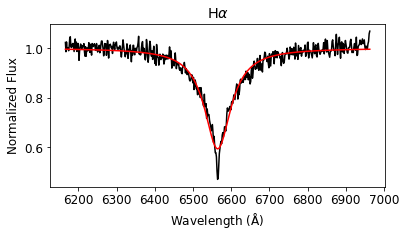

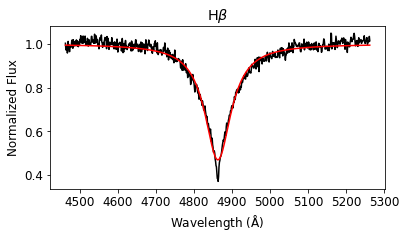

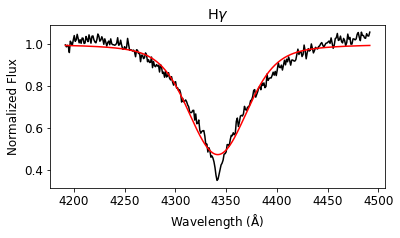

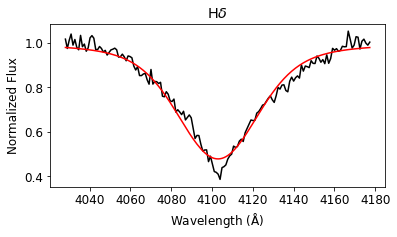

In [43]:
results = lp.labels_from_spectrum(wl, flux, make_plot = True)

In [44]:
print('Teff = %i ± %i Kelvin' % (results[0], results[1]))
print('logg = %.2f ± %.2f log[cm/s^2]' % (results[2], results[3]))

Teff = 13870 ± 272 Kelvin
logg = 8.09 ± 0.05 log[cm/s^2]


The `labels_from_spectrum` method fits all selected Balmer lines with a Voigt profile to compute their FWHM and height, and then runs the fitted parameters through the ensemble of random forest regression models to produce stellar label estimates with uncertainties. 

Both our methods produce self-consistent stellar labels that are also consistent with the prior result from Tremblay et al. (2019).

For any more details, questions, or comments please don't hesistate to contact the authors via email. You can also raise an 'issue' on GitHub for specific software bugs or feature requests. We hope you enjoy using wdtools!